Fixing timestamps...
Done fixing timestamps.


Segmenting: 100%|██████████| 250/250 [00:03<00:00, 70.77it/s]


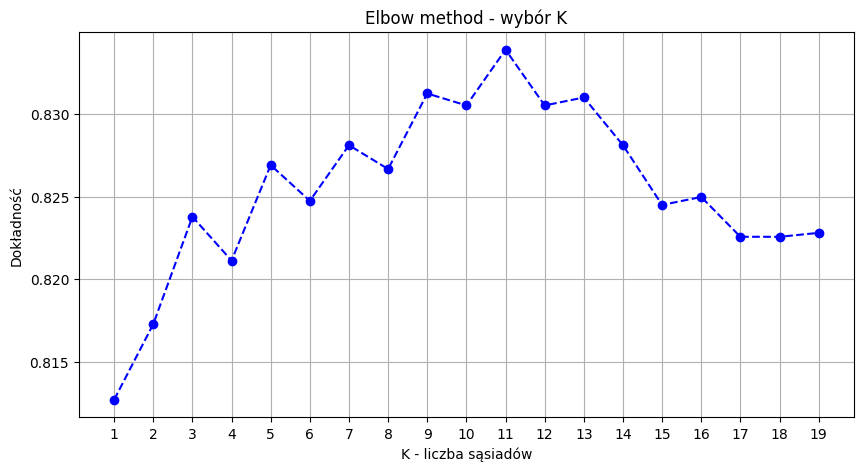

In [10]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from data_loader.data_loader import TimeWindowSegmenter
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# ekstraktor peak features
def extract_peak_features(window_df, sampling_rate=20):
    features = []
    for col in ['g_x', 'g_y', 'g_z', 'ac_x', 'ac_y', 'ac_z']:
        signal = window_df[col].values
        peaks, _ = find_peaks(signal)

        if len(peaks) > 1:
            peak_times = peaks / sampling_rate
            time_diff = np.diff(peak_times)
            avg_time_between_peaks = np.mean(time_diff)
            std_time_between_peaks = np.std(time_diff)
            features.append(avg_time_between_peaks)
            features.append(std_time_between_peaks)
        else:
            features.extend([0, 0])  # not enough peaks

        features.append(len(peaks))  # count of peaks

    return features

# ekstrakcja cech
def extract_features(window_df):
    features = []
    for col in ['g_x', 'g_y', 'g_z', 'ac_x', 'ac_y', 'ac_z']:
        col_data = window_df[col]
        features.append(col_data.mean())
        features.append(col_data.std())
        features.append(col_data.min())
        features.append(col_data.max())

    # dodawanie szczytów do cech
    peak_feats = extract_peak_features(window_df)
    return features + peak_feats

# inicjalizacja procesora danych
data_processor = TimeWindowSegmenter(
  df_path="wsidm.parquet",
  window_size=30,   # 10 sekund
  step_size=10,     # 10 sekund - ramki się nie pokrywają w danych
)

# generowanie etykiet
X = []
y = []

for window in data_processor.segment():
    feats = extract_features(window)
    label = window[data_processor.activity_column].iloc[0]
    X.append(feats)
    y.append(label)

X = np.array(X)
y = np.array(y)

# normalizacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# cross walidacja dla stabilizacji wyników
k_values = list(range(1, 20))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    
    cv_accuracies = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
    
    accuracies.append(cv_accuracies.mean())

# rysowanie wykresu
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', color='b')
plt.xlabel("K - liczba sąsiadów")
plt.ylabel("Dokładność")
plt.title("Elbow method - wybór K")
plt.xticks(k_values)
plt.grid()
plt.show()

